# Майнор "Интеллектуальный анализ данных"

# Курс "Прикладные задачи анализа данных"

## Лабораторная работа №2. RecSys

В рамках данной лабораторной работы вам предлагается решить задачу рекомендательной системы на основе следующих данных:

* **rating.csv** - рейтинги аниме по 10 бальной шкале
* **anime.csv** - описание items

Скачать данные можно [здесь](https://drive.google.com/drive/u/1/folders/1FarHUuqQq4tQSlERB9K8uEfZAZT9tQWv)

# Данные

Данные содержат информацию об предподчтениях 73,516 пользователей в 12,294 аниме. Каждый пользователь может добавить аниме и выставить рейтниг.

Anime.csv

* anime_id - идентификатор аниме (items)
* name - полное название аниме
* genre - категория/категории для аниме (разделены запятой).
* type - тип: movie, TV, OVA, etc.
* episodes - количество эпизодов (для экранизаций)
* rating - средний рейтинг по аниме.
* members - количество членов коммьюнити к аниме

Rating.csv

* user_id - идентификатор пользователя (users)
* anime_id - идентификатор аниме
* rating - рейтинг пользователя по аниме (-1 пользователь смотрел, но не оставил рейтинг).

### ``` Если вычеслительные ресурсы не позволяют решить задачу на всех данных, то необходимо это сделать на "сэмпле" данных (выбрав от 5% ids' для user и item). Этот же подход справедлив и для оценки работы алгоритомв```

In [5]:
# !apt install -y gcc build-essential

In [7]:
!pip install -U -q pandas seaborn tqdm sklearn surprise

In [490]:
from itertools import chain
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

from implicit.als import AlternatingLeastSquares
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

from tqdm.notebook import tqdm

In [2]:
sns.set_theme(style='whitegrid')

In [3]:
tqdm.pandas()

## Необходимо сделать:

In [4]:
anime = pd.read_csv("anime.csv")
ratings = pd.read_csv("rating.csv")

In [5]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [6]:
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [7]:
# здесь мы видим множество -1
# но для дальнейших экспериментов эти данные достаточно бесполезны

# человек мог посмотреть аниме, но оставить его без оценки
# но это аниме ему могло вообще не понравиться, мы этого не узнаем

# и даже если бы подумали и нашли способ использовать знание об его просмотре
# и рекомендовать его другим, то мы столкнулись бы с проблемой со второго блока
# то есть мы могли бы рекомендовать то, что кому-то не понравилось

# да и заполнить мы можем только примерно
# ну а данных у нас в целом достаточно много

# если говорить о CB подходах, то там нам эта оценка и не нужна
# поэтому с огромным удовольствием дропнем

ratings["rating"].value_counts()

 8     1646019
-1     1476496
 7     1375287
 9     1254096
 10     955715
 6      637775
 5      282806
 4      104291
 3       41453
 2       23150
 1       16649
Name: rating, dtype: int64

In [8]:
ratings = ratings[ratings.rating != -1].reset_index(drop=True)

In [9]:
data = ratings.merge(anime, how="left", on="anime_id", suffixes=["_user", "_item"]) 
data.head()

,user_id,anime_id,rating_user,name,genre,type,episodes,rating_item,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892.0
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660.0
2,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100.0
3,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657.0
4,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315.0


### Задание №1 : Exploratory analysis (2 балла):

* Распределение числа пользователей по количеству взаимодействий
* Разпределение числа "айтемов" по количеству взаимодействий
* Распределение числа рейтингов, средних рейтингов по пользователям, по "айтемам"
* и т.д. (бонус)

##### Оценка распределения рейтингов (и некоторые другие действия)

In [10]:
anime["genre"] = anime["genre"].str.split(", ")

[Text(0.5, 0, '# Rating'), Text(0, 0.5, '# Samples')]

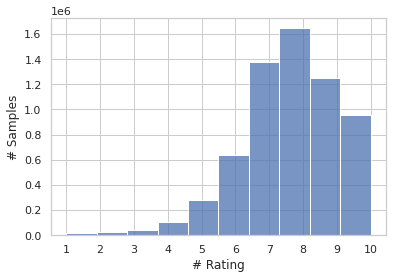

In [201]:
# люди в основном ставят оценки 7-9

ax = sns.histplot(data["rating_user"], stat="count", bins=10)
ax.set_xticks(range(1, 11))
ax.set(xlabel="# Rating", ylabel="# Samples")

[Text(0.5, 0, 'Mean Rating'), Text(0, 0.5, '# Users')]

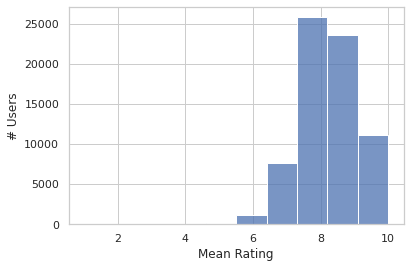

In [202]:
# средняя оценка по пользователям – 8-9

ax = sns.histplot(data.groupby("user_id")["rating_user"].agg("mean"), bins=10)
ax.set(xlabel="Mean Rating", ylabel="# Users")

[Text(0.5, 0, '# Rating'), Text(0, 0.5, '# Samples')]

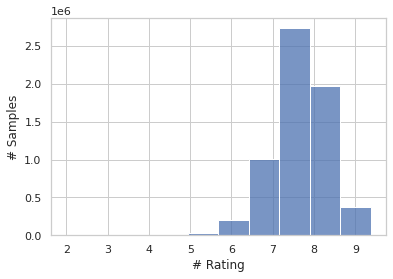

In [203]:
# оценки по айтемам примерно такие же

ax = sns.histplot(data["rating_item"], stat="count", bins=10)
ax.set(xlabel="# Rating", ylabel="# Samples")

[Text(0.5, 0, 'Mean Rating'), Text(0, 0.5, '# Anime')]

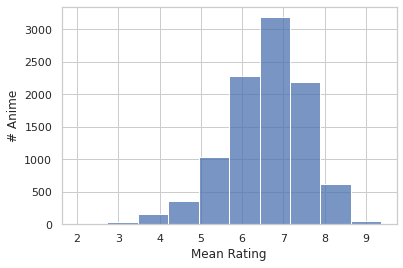

In [204]:
# средние оценки по айтемам чуть хуже, в среднем 6-8

ax = sns.histplot(data.groupby("anime_id")["rating_item"].agg("mean"), bins=10)
ax.set(xlabel="Mean Rating", ylabel="# Anime")

##### Оценка зависимости популярности аниме от его оценки

[Text(0.5, 0, '# Members'), Text(0, 0.5, 'Rating')]

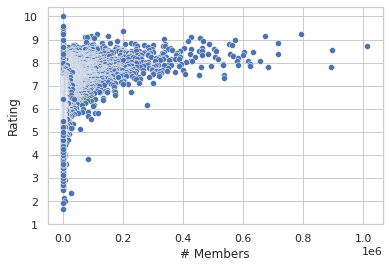

In [205]:
# видно, что прекрасные оценки часто бывают даже у ноунейм аниме
# но виден тренд увеличения оценки с увеличением коммьюнити

ax = sns.scatterplot(data=anime, x="members", y="rating")
ax.set_yticks(range(1, 11))
ax.set(xlabel="# Members", ylabel="Rating")

##### Оценка распределения рейтингов по типу (вещания) аниме

[Text(0.5, 0, 'Type'), Text(0, 0.5, 'Rating')]

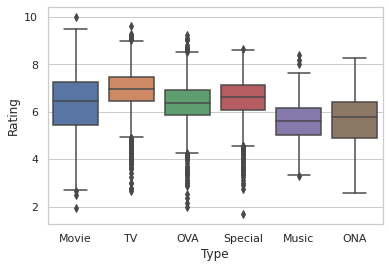

In [206]:
# видим, что самые высокие оценки на аниме по TV
# а самый большой разброс у Movie и ONA

ax = sns.boxplot(data=anime, x="type", y="rating")
ax.set(xlabel="Type", ylabel="Rating")

##### Оценка распределения рейтингов по жанру аниме

In [11]:
genre_ratings = anime.explode("genre")

[Text(0.5, 0, 'Rating'), Text(0, 0.5, 'Genre')]

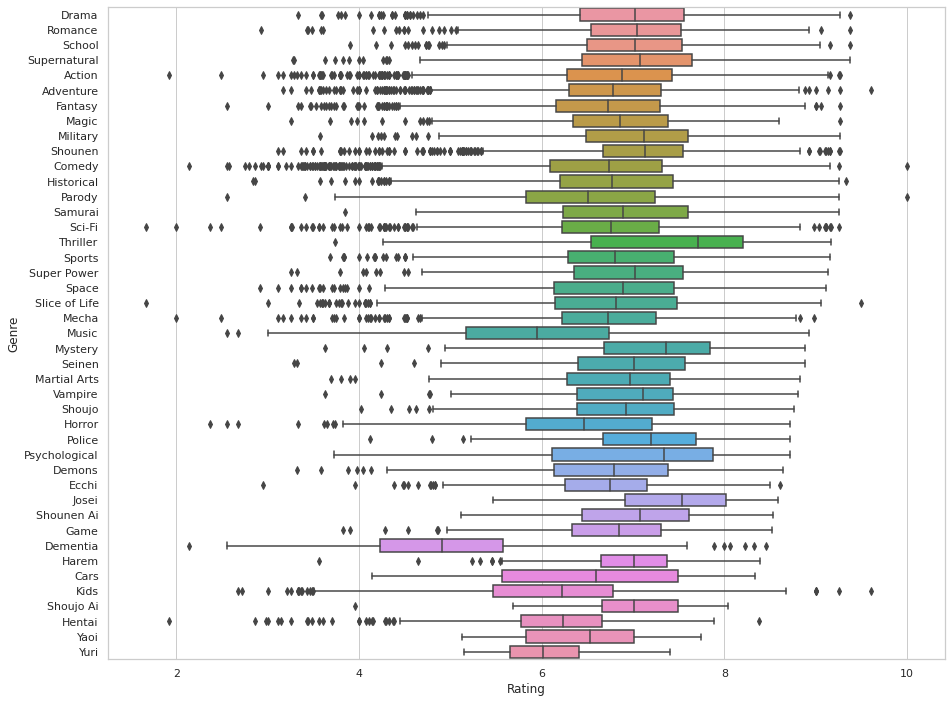

In [208]:
# видим, что людям очень нравится аниме в жанре Триллер
# но они __осуждают__ музыкальные аниме

# но вишенка на торте это жанр деменция
# видимо, его зрители по привычке включают одни и те же серии день за днём
# смотрят их, жалуются, что серии ничем друг от друга не отличаются
# ставят плохие оценки... но круг замыкается и всё начинается сначала
# деменция штука такая, да

plt.figure(figsize=(15, 12))
ax = sns.boxplot(data=genre_ratings, y="genre", x="rating", orient="h")
ax.set(xlabel="Rating", ylabel="Genre")

##### Распределение числа пользователей по количеству взаимодействий

[Text(0.5, 0, '# Users'), Text(0, 0.5, '# Interactions')]

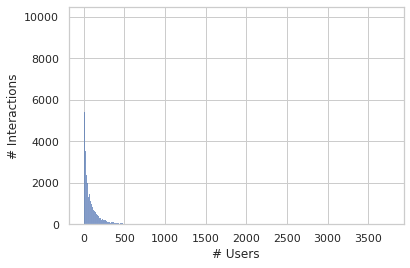

In [209]:
# мы видим огромный хвост, что говорит нам об очень большос количество пользователей с очень низким количеством взаимодействий

ax = sns.histplot(data["user_id"].value_counts())
ax.set(xlabel="# Users", ylabel="# Interactions")

[Text(0.5, 0, '# Users'), Text(0, 0.5, '# Interactions')]

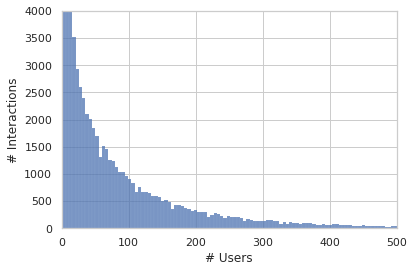

In [210]:
# из-за огромного хвоста не очень хорошо видно центральную часть
# здесь видим, что распределение довольно логичное
# больше людей – меньше взаимодействий

ax = sns.histplot(data["user_id"].value_counts())

ax.set_ylim(0, 4000)
ax.set_xlim(0, 500)
ax.set(xlabel="# Users", ylabel="# Interactions")

##### Разпределение числа "айтемов" по количеству взаимодействий

[Text(0.5, 0, '# Items'), Text(0, 0.5, '# Interactions')]

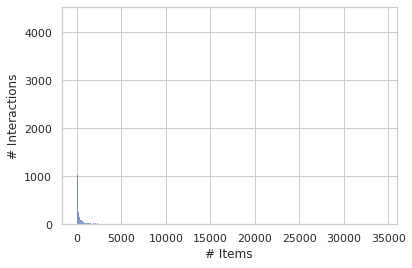

In [211]:
# аналогично предыдущему пункту

ax = sns.histplot(data["anime_id"].value_counts())
ax.set(xlabel="# Items", ylabel="# Interactions")

[Text(0.5, 0, '# Items'), Text(0, 0.5, '# Interactions')]

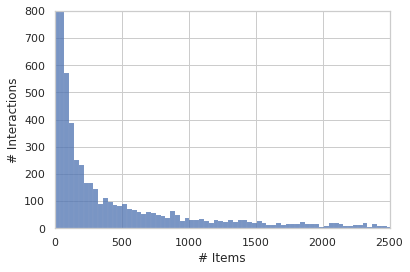

In [212]:
# аналогично

ax = sns.histplot(data["anime_id"].value_counts())

ax.set_ylim(0, 800)
ax.set_xlim(0, 2500)
ax.set(xlabel="# Items", ylabel="# Interactions")

In [296]:
# видим самые популярные аниме
# люди, видимо, очень любят Тетрадь Смерти

anime.sort_values(by=["members", "rating"], ascending=False)[:25]

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


### Задание №2 : Оценить разреженность данных по рейтингу (1/2 балла)

In [213]:
ui_matrix = data.groupby(["user_id", "anime_id"])["rating_user"].sum().unstack()
ui_matrix.isna().sum().sum() / ui_matrix.size

0.9908278218350279

### Задание №3 : Разделить данные на тренировочные и валидационные (1/2 балла)

In [13]:
MIN_RATINGS = 10
TRAIN_SIZE = 0.7

In [14]:
data = data.groupby("user_id").filter(lambda x: len(x) >= MIN_RATINGS)

In [18]:
# 70% айтемов каждого юзера в трейн, остальное в тест
# в наших данных нет юзеров без просмотров (в этом плане колд-старт не актуален)

train_df = []
test_df = []

for user_id in tqdm(data.user_id.unique()):
    
    temp = data[data.user_id == user_id]
    train_size = round(temp.shape[0] * TRAIN_SIZE)
    
    train_df.append(temp[:train_size])
    test_df.append(temp[train_size:])
    
train_df = pd.concat(train_df)
test_df = pd.concat(test_df)

  0%|          | 0/55118 [00:00<?, ?it/s]

In [291]:
print(
    "# samples in train:", train_df.shape[0], 
    "\n# samples in test:", test_df.shape[0], 
    end="\n\n"
)

print(
    "# unique users in train:", train_df.user_id.nunique(), 
    "\n# unique users in test:", test_df.user_id.nunique(), 
    end="\n\n"
)

intersecting_users = test_df[test_df.user_id.isin(train_df.user_id)]["user_id"]

print(
    "# cold-users in test:", test_df.user_id.nunique() - intersecting_users.nunique()
)

# samples in train: 4393940 
# samples in test: 1884419

# unique users in train: 55118 
# unique users in test: 55118

# cold-users in test: 0


In [292]:
print(
    "# unique users in train:", train_df.anime_id.nunique(), 
    "# unique users in test:", test_df.anime_id.nunique()
)

intersecting_items = test_df[test_df.anime_id.isin(train_df.anime_id)]["anime_id"]

print(
    "# cold-items in test:", test_df.anime_id.nunique() - intersecting_items.nunique()
)

# unique users in train: 8156 # unique users in test: 9082
# cold-items in test: 1770


### Задание №7 Оценить работу алгоритмов выбрав одну из метрик, сделать вывод по результатам работы (2 балла):

* MAP@k
* NDCG@k
* MRR

In [19]:
# метрики понятно откуда

def mean_reciprocal_rank(rs):
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])

def r_precision(r):
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])

def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [208]:
ranking_table = test_df.groupby("user_id").agg({"anime_id": list})
ranking_table = ranking_table.reset_index()

In [21]:
# да и это тоже, только переделал немного

def evaluate(ranking_table):
    """
    Evaluates recommender systems
    """
    
    ranking_table['top_3'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.anime_id_pred[:3]], axis=1)
    ranking_table['top_5'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.anime_id_pred[:5]], axis=1)
    ranking_table['top_10'] = ranking_table.apply(lambda x: [int(pred in x.anime_id) for pred in x.anime_id_pred[:10]], axis=1)
    
    score_results = pd.DataFrame(index=['top_3', 'top_5', 'top_10'], columns=['MRR', 'MAP@K', 'NDCG@k'])
    
    for top in tqdm([3, 5, 10]):
        score_results.loc['top_' + str(top), 'MAP@K'] = mean_reciprocal_rank(list(ranking_table['top_' + str(top)].values))
        score_results.loc['top_' + str(top), 'MRR'] = mean_average_precision(list(ranking_table['top_' + str(top)].values))
        score_results.loc['top_' + str(top), 'NDCG@k'] = np.mean([ndcg_at_k(i, top) for i in list(ranking_table['top_' + str(top)].values)])
    
    return score_results

### Задание №4 : Решить задачу на основе предложения всем юзерам наиболее популярных item (1 балл)

In [45]:
# Создаём список наиболее популярных аниме путём сортирования по убыванию относительно размера коммьюнити

popular_anime = anime.sort_values(by=["members", "rating"], ascending=False)

In [351]:
# Функция рекомендации популярных аниме

def recommend_popular(user_id, k=5, include_history=True):
    if include_history:
        user_data = train_df[train_df.user_id == user_id]
        seen_mask = popular_anime.anime_id.isin(user_data.anime_id)
        return popular_anime[~seen_mask]["anime_id"][:k].values
    
    return popular_anime["anime_id"][:k].values

In [331]:
recommend_popular(3, k=10)

array([ 6547,  1575,  9253, 10620,  4224,   269,   226, 22319,   121,
        2904])

In [348]:
# С фильтрацией ранее просмотренного

ranking_table["anime_id_pred"] = ranking_table["user_id"].progress_apply(
    recommend_popular, include_history=True, k=10
)

evaluate(ranking_table, recommend_popular, k=10, include_history=True)

  0%|          | 0/55118 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,MRR,MAP@K,NDCG@k
top_3,0.3249,0.324694,0.403301
top_5,0.334939,0.343727,0.426076
top_10,0.319594,0.363036,0.43742


In [380]:
# Без фильтрации просмотренного ранее

ranking_table["anime_id_pred"] = ranking_table["user_id"].progress_apply(
    recommend_popular, include_history=False, k=10
)

evaluate(ranking_table)

  0%|          | 0/55118 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

,MRR,MAP@K,NDCG@k
top_3,0.204375,0.196751,0.3388
top_5,0.221069,0.212638,0.366059
top_10,0.219186,0.22063,0.370917


In [ ]:
# в целом, достаточно неплохой результат
# хотя можно пошаманить и сделать лучше

### Задание №5 : Решить задачу на основе коллоборативной фильтрации (2 балла)

* Реализовать один из методов коллоборативной фильтрации SVD, SVD++, ALS, ALS with implicit feedback

### Solution via SVD

In [67]:
# Я мог бы вручную реализовать recsys на svd из numpy примерно так:

# u, d, v = svd(X_data)

# U = u[:, :k]
# D = np.diag(d)[:k, :k]
# V = v[:k, :]

# X_svd = U @ D @ V

# Но думаю, что оптимальнее для всех будет воспользоваться решением из suprise (и др.)

In [24]:
# Готовим обучающие данные для SVD

reader = Reader(rating_scale=(1, 10))

svd_train = Dataset.load_from_df(train_df[["user_id", "anime_id", "rating_user"]], reader=reader)
svd_train = svd_train.build_full_trainset()

In [25]:
# Обучаем модель

svd = SVD(random_state=42, n_factors=10, n_epochs=30, verbose=True)
svd.fit(svd_train)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29


In [54]:
# немного измененная функция оценки с семинарского ноутбука
# surprise медленный, а я работаю со всеми данными (так интереснее!)
# поэтому я предсказываю рейтинги не для всех аниме, а для 500 наиболее частотных

def compute_ranking_predictions(
    algo,
    data,
    user_col,
    item_col,
    pred_col,
    remove_seen=False,
):
    preds = []
    for user in tqdm(data[user_col].unique(), desc="Iterating users"):
#         for item in data[item_col].unique():
        for item in popular_anime["anime_id"][:500].values:
            preds.append([user, item, algo.predict(user, item).est])

    all_predictions = pd.DataFrame(data=preds, columns=[user_col, item_col, pred_col])

    if remove_seen:
        temp_df = pd.concat(
            [
                data[[user_col, item_col]],
                pd.DataFrame(
                    data=np.ones(data.shape[0]), columns=["dummy_col"], index=data.index
                ),
            ],
            axis=1,
        )
        merged = pd.merge(temp_df, all_predictions, on=[user_col, item_col], how="outer")
        return merged[merged["dummy_col"].isnull()].drop("dummy_col", axis=1)
    else:
        return all_predictions

In [55]:
%%time
predictions = compute_ranking_predictions(
    svd, 
    train_df, 
    user_col='user_id', 
    item_col='anime_id',
    pred_col='pred', 
    remove_seen=True
)

predictions.head()

Iterating users:   0%|          | 0/55118 [00:00<?, ?it/s]

CPU times: user 7min 10s, sys: 2min 15s, total: 9min 26s
Wall time: 7min 1s


,user_id,anime_id,pred
4393940,3,6547,8.504571
4393941,3,1575,9.702781
4393942,3,9253,9.499513
4393943,3,10620,8.353885
4393944,3,4224,8.618192


In [58]:
predictions = predictions.sort_values(by=["user_id", "pred"], ascending=[True, False])

In [60]:
predictions.head()

,user_id,anime_id,pred
4393949,3,2904,9.909725
4393941,3,1575,9.702781
4394242,3,9969,9.645192
4393970,3,11061,9.574886
4393966,3,4181,9.573136


In [61]:
predictions = predictions.groupby("user_id").agg({"anime_id": lambda x: list(x)[:10]})
predictions.head()

,anime_id
user_id,
3,"[2904, 1575, 9969, 11061, 4181, 9253, 918, 289..."
5,"[19, 457, 578, 523, 1, 164, 437, 43, 572, 5114]"
7,"[28977, 9253, 28891, 30276, 5114, 4282, 9969, ..."
8,"[431, 28977, 5114, 199, 24415, 28891, 23273, 9..."
11,"[9969, 918, 4282, 7785, 457, 28977, 2251, 1106..."


In [66]:
# здесь мы видим, что модель работает явно похуже той,
# которая рекомендует топ аниме
# и это понятно, потому что мы брали в учёт не 12к тайтлов, а всего 500
# так бы скор был значительно выше

ranking_table["anime_id_pred"] = predictions["anime_id"].values
evaluate(ranking_table)

  0%|          | 0/3 [00:00<?, ?it/s]

,MRR,MAP@K,NDCG@k
top_3,0.13159,0.13267,0.171844
top_5,0.145623,0.150031,0.200054
top_10,0.153453,0.167504,0.230144


In [ ]:
# но в целом нам уже здесь понятно, что люди смотрят аниме достаточно рандомно
# а взаимодействия между юзерами не так важны
# полагаю, что в content-based будет то же самое, если не хуже

In [69]:
# условие задания, конечно, говорит об использовании одного алгоритма
# но зачем использовать один, если можешь потестить сразу несколько и хоть на будущее запомнить?))

# в конце концов, на работе я хоть и пилю поисковики, но когда ж я ещё рексисами займусь? Неизвестно. Так что давайте пробовать
# (зато не успеет надоесть)

### Solution via ALS

In [ ]:
# будем пробовать решить сразу CF и CB подходами через ALS
# здесь начнём с ALS

In [107]:
# создаём разные сопоставления

users = train_df.user_id.unique()
items = train_df.anime_id.unique()

id2user = {key: value for key, value in enumerate(users)}
id2items = {key: value for key, value in enumerate(items)} 

rating = list(train_df.rating_user)

In [74]:
# и ещё

user2id = {value: key for key, value in id2user.items()}
items2id = {value: key for key, value in id2items.items()}

In [76]:
# всё во благо sparse матриц

rows = train_df.user_id.map(user2id)
# Get the associated row indices

cols = train_df.anime_id.map(items2id)
# Get the associated column indices

In [181]:
# и наконец

rating_sparse = csr_matrix((rating, (rows, cols)), shape=(len(user2id), len(items2id)))
print(rating_sparse.shape)

(55118, 8156)


In [291]:
# работаем с ALS моделью

als = AlternatingLeastSquares(num_threads=12, factors=200, iterations=100, regularization=0.01)

In [292]:
als.fit(rating_sparse)

  0%|          | 0/100 [00:00<?, ?it/s]

In [295]:
user_ids = list(id2user.keys())

In [306]:
def map_idx(mapping, idx):
    return mapping[idx]

map_idx = np.vectorize(map_idx)

In [297]:
predictions, _ = als.recommend(user_ids, rating_sparse[user_ids], N=10, filter_already_liked_items=True)
predictions = map_idx(id2items, predictions)

In [298]:
predictions = pd.DataFrame({"user_id": user_ids, "anime_id_pred": predictions.tolist()})
predictions = predictions.set_index("user_id")
predictions.head()

,anime_id_pred
user_id,
0,"[121, 1565, 223, 11061, 431, 1120, 874, 10793,..."
1,"[9863, 9513, 10213, 523, 15117, 14833, 2112, 1..."
2,"[392, 527, 19429, 19685, 18753, 11785, 9515, 7..."
3,"[2787, 6773, 9041, 11111, 20, 8074, 11617, 886..."
4,"[585, 1119, 1829, 47, 1033, 371, 437, 1943, 72..."


In [299]:
ranking_table["anime_id_pred"] = predictions["anime_id_pred"].values
evaluate(ranking_table)

  0%|          | 0/3 [00:00<?, ?it/s]

,MRR,MAP@K,NDCG@k
top_3,0.077323,0.077655,0.107409
top_5,0.091136,0.092559,0.133752
top_10,0.104707,0.1094,0.169091


In [ ]:
# видим, что через ALS стало только хуже
# но здесь это вероятно из-за того, что можно ещё поиграть с гиперпараметрами
# я пробовал увеличивать количество факторов и только этим смог поднимать скор на тесте

### Задание №6 Решить задачу на основе контент-based подхода, выбрав один из методов решения (2 балла):

* На основание векторов с факторизационной матрицы
* При помощи "ембеддингов"  item'ов

In [441]:
watched_anime = train_df.groupby("user_id").agg({"anime_id": list})
watched_anime = watched_anime["anime_id"].to_dict()

In [486]:
# каждому юзеру подбираем 25 наиболее похожих на него по интересам

predictions, _ = als.similar_users(user_ids, N=25)
predictions = map_idx(id2user, predictions)

In [487]:
# функция для предсказания аниме по похожим юзерам
# хотел ещё взвешивать частотности аниме относительно их оценок у ближайших юзеров
# но это было бы более медленно и муторно, поэтому отказался
# едва ли это сильно подняло бы качество в нашем случае

def recommend_content(user_idx, k=5):
    """
    Recommends items based on favourite anime of other users
    """
    rel_items = [watched_anime[idx] for idx in user_idx]
    rel_items = tuple(chain.from_iterable(rel_items))
    
    item_counts = Counter(rel_items)
    return [x[0] for x in item_counts.most_common(k)]

In [488]:
predictions = [recommend_content(pred) for pred in tqdm(predictions)]

  0%|          | 0/55118 [00:00<?, ?it/s]

In [489]:
# ... и ещё раз подвтерждаем гипотезу о том, 
# что анимешники в большинстве своём... кхм-кхм
# не особо привержены к просмотру каких-то определённых вещей
# потому что веса из факторизационной матрицы нам не помогли в принципе
# а предсказание самых популярных тайтлов и вообще оказалось наиболее эффективным (с большим отрывом)

# Всё!

ranking_table["anime_id_pred"] = predictions
evaluate(ranking_table)

  0%|          | 0/3 [00:00<?, ?it/s]

,MRR,MAP@K,NDCG@k
top_3,0.000529,0.000529,0.000919
top_5,0.001485,0.00148,0.002899
top_10,0.001485,0.00148,0.002899


#### P.S. Все выводы и метрики я считал прямо по ходу выполнения. Надеюсь, Вам понравилось это читать :)